$ \newcommand{\Bra}[1]{\left\langle #1 \right|} $
$ \newcommand{\Ket}[1]{\left| #1 \right\rangle} $

# NQR Hamiltonian: Zeeman Basis

In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as op

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import e as e_charge
from scipy.constants import hbar, mega
from scipy.optimize import fsolve
import sympy as sp
from sympy.physics.matrices import msigma

import nmrlib.core as nmr
import nmrlib.quantum as quant
from src import ROOT
from src.utils import find_max_min

FIGSIZE = mpl.rcParams["figure.figsize"]

class Bunch(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

## Eigenstates and eigenenergies

The first step is to find the states and energies. We first define the spin operators.

In [3]:
I = sp.Rational(3, 2)
sym = Bunch({})
sym.I = {}
sym.I['y'] = sp.Matrix([[0, -sp.I*sp.sqrt(3), 0, 0], [sp.I*sp.sqrt(3), 0, -sp.I*2, 0], [0, sp.I*2, 0, -sp.I*sp.sqrt(3)], [0, 0, sp.I*sp.sqrt(3), 0]])/2
sym.I['x'] = sp.Matrix([[0, sp.sqrt(3), 0, 0], [sp.sqrt(3), 0, 2, 0], [0, 2, 0, sp.sqrt(3)], [0, 0, sp.sqrt(3), 0]])/2
sym.I['z'] = sp.Matrix([[I, 0, 0, 0], [0, I - 1, 0, 0], [0, 0, I - 2, 0], [0, 0, 0, I - 3]])
for i in ['x', 'y', 'z']:
    display(sym.I[i])

Matrix([
[        0, sqrt(3)/2,         0,         0],
[sqrt(3)/2,         0,         1,         0],
[        0,         1,         0, sqrt(3)/2],
[        0,         0, sqrt(3)/2,         0]])

Matrix([
[          0, -sqrt(3)*I/2,           0,            0],
[sqrt(3)*I/2,            0,          -I,            0],
[          0,            I,           0, -sqrt(3)*I/2],
[          0,            0, sqrt(3)*I/2,            0]])

Matrix([
[3/2,   0,    0,    0],
[  0, 1/2,    0,    0],
[  0,   0, -1/2,    0],
[  0,   0,    0, -3/2]])

It is easier to create Hamiltonian in quadrupolar basis first.

In [4]:
sym.delta = sp.symbols('delta', real=True, positive=True)
sym.X = [None]*4
sym.X[0] = sp.eye(4)[:, 0]
sym.X[1] = sp.eye(4)[:, 1]
sym.X[2] = sp.eye(4)[:, 2]
sym.X[3] = sp.eye(4)[:, 3]
Hq = np.diag([1, -1, -1, 1]) # Quadrupolar Hamiltonian divided by wQ*rho
TRIGSUBS = {sp.sin(sym.delta)**2: (1 - sp.cos(2*sym.delta))/2, sp.cos(sym.delta)**2: (sp.cos(2*sym.delta) + 1)/2}
sym.H_qbasis = sp.simplify(sp.Matrix(Hq))
sym.H_qbasis

Matrix([
[1,  0,  0, 0],
[0, -1,  0, 0],
[0,  0, -1, 0],
[0,  0,  0, 1]])

Find eigenvalues and eigenvectors in quadrupolar basis.

In [5]:
a, b, c, d, f = sp.symbols('a b c d f')
H_temp = sp.Matrix([[a, 0, -f, 0], [0, b, 0, f], [-f, 0, c, 0], [0, f, 0, d]])
sym.eig_qbasis = H_temp.eigenvects()
H_temp

Matrix([
[ a, 0, -f, 0],
[ 0, b,  0, f],
[-f, 0,  c, 0],
[ 0, f,  0, d]])

In [6]:
Hsubs = {a: sym.H_qbasis[0, 0], b: sym.H_qbasis[1, 1], c: sym.H_qbasis[2, 2], d: sym.H_qbasis[3, 3],
         f: sym.H_qbasis[1, 3]}
for i in range(4):
    E, X = sp.simplify(sym.eig_qbasis[i][0].subs(Hsubs)), sp.simplify(sym.eig_qbasis[i][2][0].subs(Hsubs))
    display(E)#.subs({sym.delta: 0, sym.alpha: 0}))
    display(X)#.subs(sym.delta, 0))  
    print('='*80)

-1

Matrix([
[0],
[0],
[1],
[0]])

1

Matrix([
[nan],
[  0],
[  1],
[  0]])

-1

Matrix([
[  0],
[nan],
[  0],
[  1]])

1

Matrix([
[0],
[0],
[0],
[1]])

Now change basis to Zeeman basis by a unitary operator $ U = \sum_k \Ket{b^{(k)}} \Bra{a^{(k)}} $ (assuming going from $ A $ basis to $ B $ basis).

In [7]:
sym.U = sp.zeros(4, 4)
for k in range(4):
    bk = sym.X[k]
    ak = sym.Xp[k]
    sym.U += bk*ak.T
sym.U

AttributeError: 'Bunch' object has no attribute 'Xp'

The Hamiltonian and eigenvectors in the Zeeman basis are then $ U^\dagger H U $ and $ U^\dagger \Ket{m''} $, respectively. 

In [ ]:
sym.H = sp.simplify(sp.simplify((sym.U.T*sym.H_qbasis*sym.U)).subs(TRIGSUBS))
sym.H

In [ ]:
Hsubs = {a: sym.H_qbasis[0, 0], b: sym.H_qbasis[1, 1], c: sym.H_qbasis[2, 2], d: sym.H_qbasis[3, 3],
         f: sym.H_qbasis[1, 3]}
for i in range(4):
    E, X = sp.simplify(sym.eig_qbasis[i][0].subs(Hsubs)), sp.simplify(sym.U.T*(sym.eig_qbasis[i][2][0].subs(Hsubs)))
    display(E.subs(TRIGSUBS).simplify())#.subs({sym.delta: 0, sym.alpha: 0}))
    display((sym.U.T*sp.simplify(sym.eig_qbasis[i][2][0].subs(Hsubs))))
    display(X.subs(TRIGSUBS).simplify())#.subs(sym.delta, 0))  
    print('='*80)

Alternatively, I propose that the eigenvalues and eigenvectors are defined in the following way:

In [8]:
sym.delta = sp.symbols('delta', real=True)

sym.Epp = {}
sym.Xpp = {}
sym.Xpp['3/2'] = sp.cos(sym.delta)*sym.X[0] + sp.sin(sym.delta)*sym.X[2]
sym.Xpp['-3/2'] = sp.cos(sym.delta)*sym.X[3] + sp.sin(sym.delta)*sym.X[1]
sym.Xpp['1/2'] = sp.cos(sym.delta)*sym.X[1] - sp.sin(sym.delta)*sym.X[3]
sym.Xpp['-1/2'] = sp.cos(sym.delta)*sym.X[2] - sp.sin(sym.delta)*sym.X[0]
sym.Epp['3/2'] = 1/sp.cos(2*sym.delta)
sym.Epp['-3/2'] = 1/sp.cos(2*sym.delta)
sym.Epp['1/2'] = -1/sp.cos(2*sym.delta)
sym.Epp['-1/2'] = -1/sp.cos(2*sym.delta)

In [9]:
for i in ['3/2', '1/2', '-1/2', '-3/2']:
    print(i)
    display(sym.Epp[i])
    display(sym.Xpp[i])
    print('='*80)

3/2


1/cos(2*delta)

Matrix([
[cos(delta)],
[         0],
[sin(delta)],
[         0]])

1/2


-1/cos(2*delta)

Matrix([
[          0],
[ cos(delta)],
[          0],
[-sin(delta)]])

-1/2


-1/cos(2*delta)

Matrix([
[-sin(delta)],
[          0],
[ cos(delta)],
[          0]])

-3/2


1/cos(2*delta)

Matrix([
[         0],
[sin(delta)],
[         0],
[cos(delta)]])

Let us first verify that these are in fact eigenvalues and eigenvectors of the Hamiltonian by checking if $ H \Ket{m''} - E_{m''} \Ket{m''} = 0 $

In [10]:
alpha = np.linspace(0, 10)
delta = np.linspace(0, np.pi/12)
for i in sym.Epp:
    E, X = sym.Epp[i].subs(GSUBS), (sym.Xpp[i].subs(ASUBS).subs(GSUBS))
    a, d = np.cos(np.pi/12), np.pi/25
    #display(E.subs(sym.delta, d).subs(sym.alpha, a))
    #display(X.subs(sym.delta, d).subs(sym.alpha, a))
    f = sp.lambdify([sym.alpha, sym.delta], sym.H*X - E*X)
    for a in alpha:
        for d in delta:
            if not np.all(np.isclose(f(a, d), 0)):
                print(f(a, d))

NameError: name 'GSUBS' is not defined

Since nothing printed, that means we have proper eigenvalues and eigenvectors.

## Transition Frequencies

Now we find all allowed transition frequencies (negative ones are excluded).

In [11]:
sym.freq = {}
sym.freq['x'] = {}
sym.freq['y'] = {}
sym.freq['z'] = {}
exclude = [('3/2', '-1/2'), ('3/2', '-3/2'), ('3/2', '1/2')] # because g+ >= g-
for i in sym.Epp:
    for j in sym.Epp:
        Xi, Xj = sym.Xpp[i], sym.Xpp[j]
        for d in ['x', 'y', 'z']:
            #m = sp.simplify((Xi.T*sym.I[d]*Xj)[0])
            #if m != 0 and i != j and (i, j) not in exclude: # if transition is not zero and frequency is > 0
            Ei, Ej = sym.Epp[i], sym.Epp[j]
            if Ej - Ei != 0: # if transition is not zero
                sym.freq[d][(i, j)] = Ej - Ei
                print(f'{i} -> {j}')
                display(sym.freq[d][(i, j)])
                print('-'*15)

3/2 -> 1/2


-2/cos(2*delta)

---------------
3/2 -> 1/2


-2/cos(2*delta)

---------------
3/2 -> 1/2


-2/cos(2*delta)

---------------
3/2 -> -1/2


-2/cos(2*delta)

---------------
3/2 -> -1/2


-2/cos(2*delta)

---------------
3/2 -> -1/2


-2/cos(2*delta)

---------------
-3/2 -> 1/2


-2/cos(2*delta)

---------------
-3/2 -> 1/2


-2/cos(2*delta)

---------------
-3/2 -> 1/2


-2/cos(2*delta)

---------------
-3/2 -> -1/2


-2/cos(2*delta)

---------------
-3/2 -> -1/2


-2/cos(2*delta)

---------------
-3/2 -> -1/2


-2/cos(2*delta)

---------------
1/2 -> 3/2


2/cos(2*delta)

---------------
1/2 -> 3/2


2/cos(2*delta)

---------------
1/2 -> 3/2


2/cos(2*delta)

---------------
1/2 -> -3/2


2/cos(2*delta)

---------------
1/2 -> -3/2


2/cos(2*delta)

---------------
1/2 -> -3/2


2/cos(2*delta)

---------------
-1/2 -> 3/2


2/cos(2*delta)

---------------
-1/2 -> 3/2


2/cos(2*delta)

---------------
-1/2 -> 3/2


2/cos(2*delta)

---------------
-1/2 -> -3/2


2/cos(2*delta)

---------------
-1/2 -> -3/2


2/cos(2*delta)

---------------
-1/2 -> -3/2


2/cos(2*delta)

---------------


Some of these transitions will be weaker than others, so we calculate the magnetic moment of each frequency to determine its intensity. We first create Python lambda functions that we can use to store the magnetic moment expressions and treat as Python functions.

In [12]:
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
up = sp.Matrix([1, 0])
down = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
beta = {}
beta['x'] = {}#sp.Matrix(np.zeros((4, 4)))
beta['y'] = {}#sp.Matrix(np.zeros((4, 4)))
beta['z'] = {}#sp.Matrix(np.zeros((4, 4)))
for d in ['x', 'y', 'z']:
    for i, tran in enumerate(sym.freq[d]):
        p, q = tran
        Xp, Xq = sym.Xpp[p], sym.Xpp[q]
        wpq = sym.freq[d][tran]
        beta = sp.simplify(Xp.T*sym.I[d]*Xq)
        #beta[d][tran] = sp.simplify(Xp.T*sym.I[d]*Xq)
        compi, compj = 0, 0
        for m, d2 in enumerate(['x', 'y', 'z']):
            betam = (Xp.T*sym.I[d2]*Xq)[0]
            compi += c[m]*sp.re(betam)
            compj += c[m]*sp.im(betam)
        if compi != 0 or compj != 0:
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq/(2*(2*I + 1))*(down.T*Vmid*up)*beta*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp[0]# + sp.conjugate(_Iexp)
            sym.Iexp[d][tran] = sp.lambdify([sym.delta, sym.t], Iexp)
        else:
            sym.Iexp[d][tran] = sp.lambdify([sym.delta, sym.t], 0)

In [13]:
sym.Iexp

{'x': {('3/2', '1/2'): <function _lambdifygenerated(delta, t)>,
  ('3/2', '-1/2'): <function _lambdifygenerated(delta, t)>,
  ('-3/2', '1/2'): <function _lambdifygenerated(delta, t)>,
  ('-3/2', '-1/2'): <function _lambdifygenerated(delta, t)>,
  ('1/2', '3/2'): <function _lambdifygenerated(delta, t)>,
  ('1/2', '-3/2'): <function _lambdifygenerated(delta, t)>,
  ('-1/2', '3/2'): <function _lambdifygenerated(delta, t)>,
  ('-1/2', '-3/2'): <function _lambdifygenerated(delta, t)>},
 'y': {('3/2', '1/2'): <function _lambdifygenerated(delta, t)>,
  ('3/2', '-1/2'): <function _lambdifygenerated(delta, t)>,
  ('-3/2', '1/2'): <function _lambdifygenerated(delta, t)>,
  ('-3/2', '-1/2'): <function _lambdifygenerated(delta, t)>,
  ('1/2', '3/2'): <function _lambdifygenerated(delta, t)>,
  ('1/2', '-3/2'): <function _lambdifygenerated(delta, t)>,
  ('-1/2', '3/2'): <function _lambdifygenerated(delta, t)>,
  ('-1/2', '-3/2'): <function _lambdifygenerated(delta, t)>},
 'z': {('3/2', '1/2'): <func

With the functions defined, we can now visualize the spectrum.

-0.2165063509461097 0.28867513459481287


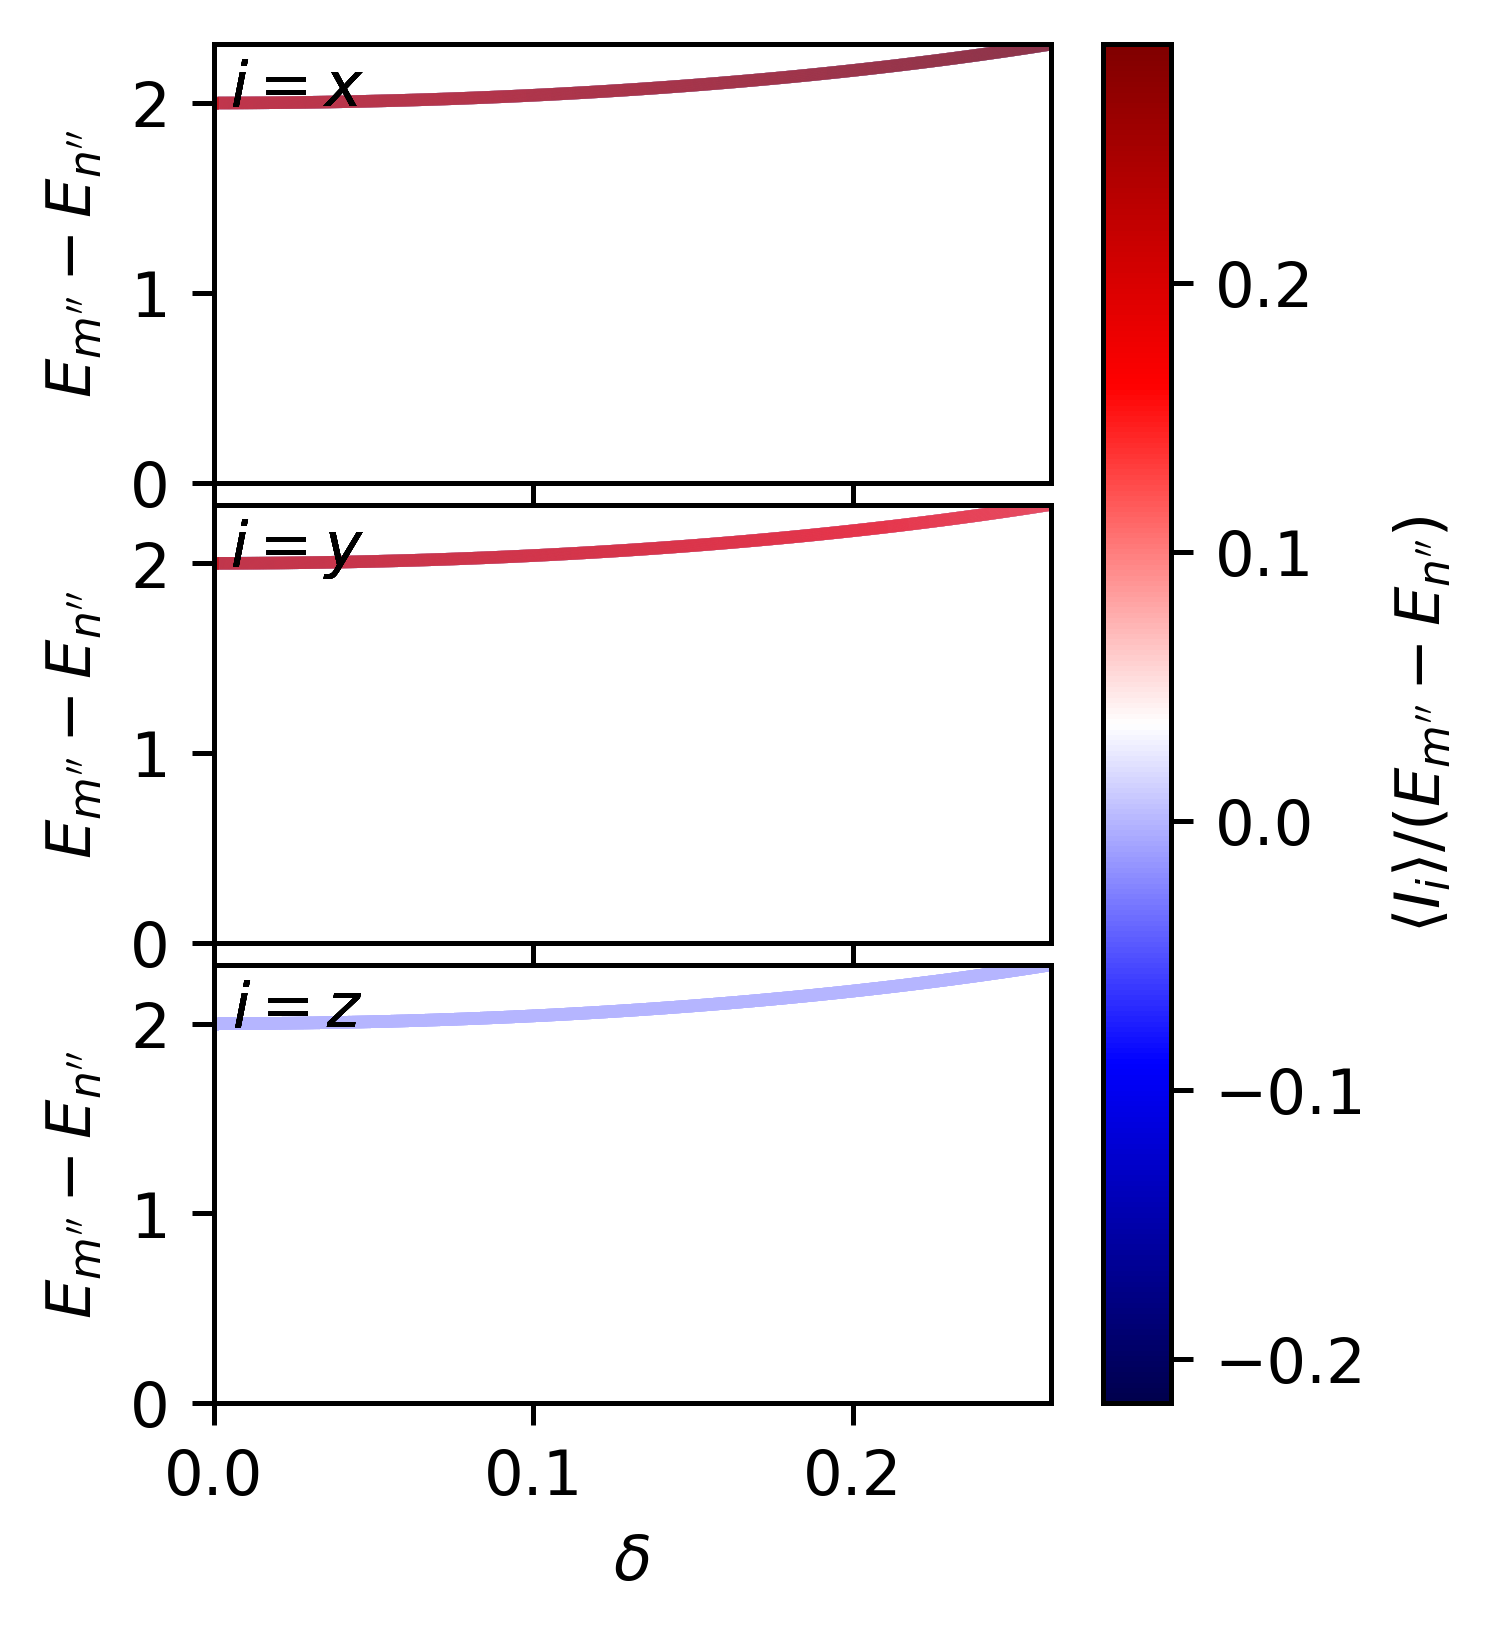

In [14]:
delta = np.linspace(0, np.pi/12, 5000)
xdata = {}
ydata = {}
cdata = {}
for i, d in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        wpq = sp.lambdify([sym.delta], sym.freq[d][tran])(delta)
        x = delta[wpq >= 0]
        y = wpq[wpq >= 0]
        y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
        _Iexp = Iexp[tran](delta, 0)
        if type(_Iexp) == np.ndarray:
            c = _Iexp[wpq >= 0]
        elif _Iexp == 0:
            c = np.zeros(x.size)
        if x.size == 0 and y.size == 0 and c.size == 0:
            x = np.zeros(delta.size)
            y = np.zeros(delta.size)
            c = np.zeros(delta.size)            
        if np.all(np.isclose(np.imag(c), np.zeros(x.size))):
            c = np.real(c)
        elif np.all(np.isclose(np.real(c), np.zeros(x.size))):
            c = np.imag(c)
        if not np.all(y == 0):
            c = c#/y
        xdata[d][tran] = x.copy()
        ydata[d][tran] = y.copy()
        cdata[d][tran] = c.copy()
        #ax[i].plot(x, c, label=tran)

# mpl.style.use('default')
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/2, FIGSIZE[1]),
                       dpi=450)
cmin, cmax = 100, -100
for i, d in enumerate(sym.Iexp):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    _cmax, _cmin = find_max_min([(c) for c in cdata_list])
    if _cmax > cmax:
        cmax = _cmax
    if _cmin < cmin:
        cmin = _cmin
print(cmin, cmax)
for i, d in enumerate(['x', 'y', 'z']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    ymax, ymin = find_max_min(ydata_list)
    norm = plt.Normalize(cmin, cmax)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        y = ydata[d][tran]
        c = np.abs(cdata[d][tran])#/cmin
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = mpl.collections.LineCollection(segments, cmap='seismic', norm=norm)
        lc.set_array(c)
        lc.set_linewidth(2)
        line = ax[i].add_collection(lc)
        ax[i].set_xlim(delta.min(), delta.max())
        ax[i].set_ylim(ymin, ymax)
        ax[i].set_ylabel(r"$ E_{m''} - E_{n''}$")
        ax[i].set_facecolor("white")
        ax[i].text(0.1, 0.9,
                   r"$i = " + d + "$",
                   color='k',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
# D_label = sp.nsimplify(D, constants=[sp.pi])
# if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
# else:
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[-1].set_xlabel(r'$\delta$')
cbar = fig.colorbar(line, ax=ax[0:], location='right')#, shrink=0.6)
cbar.set_label(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
# #fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

Text(0.5, 0, '$\\alpha$')

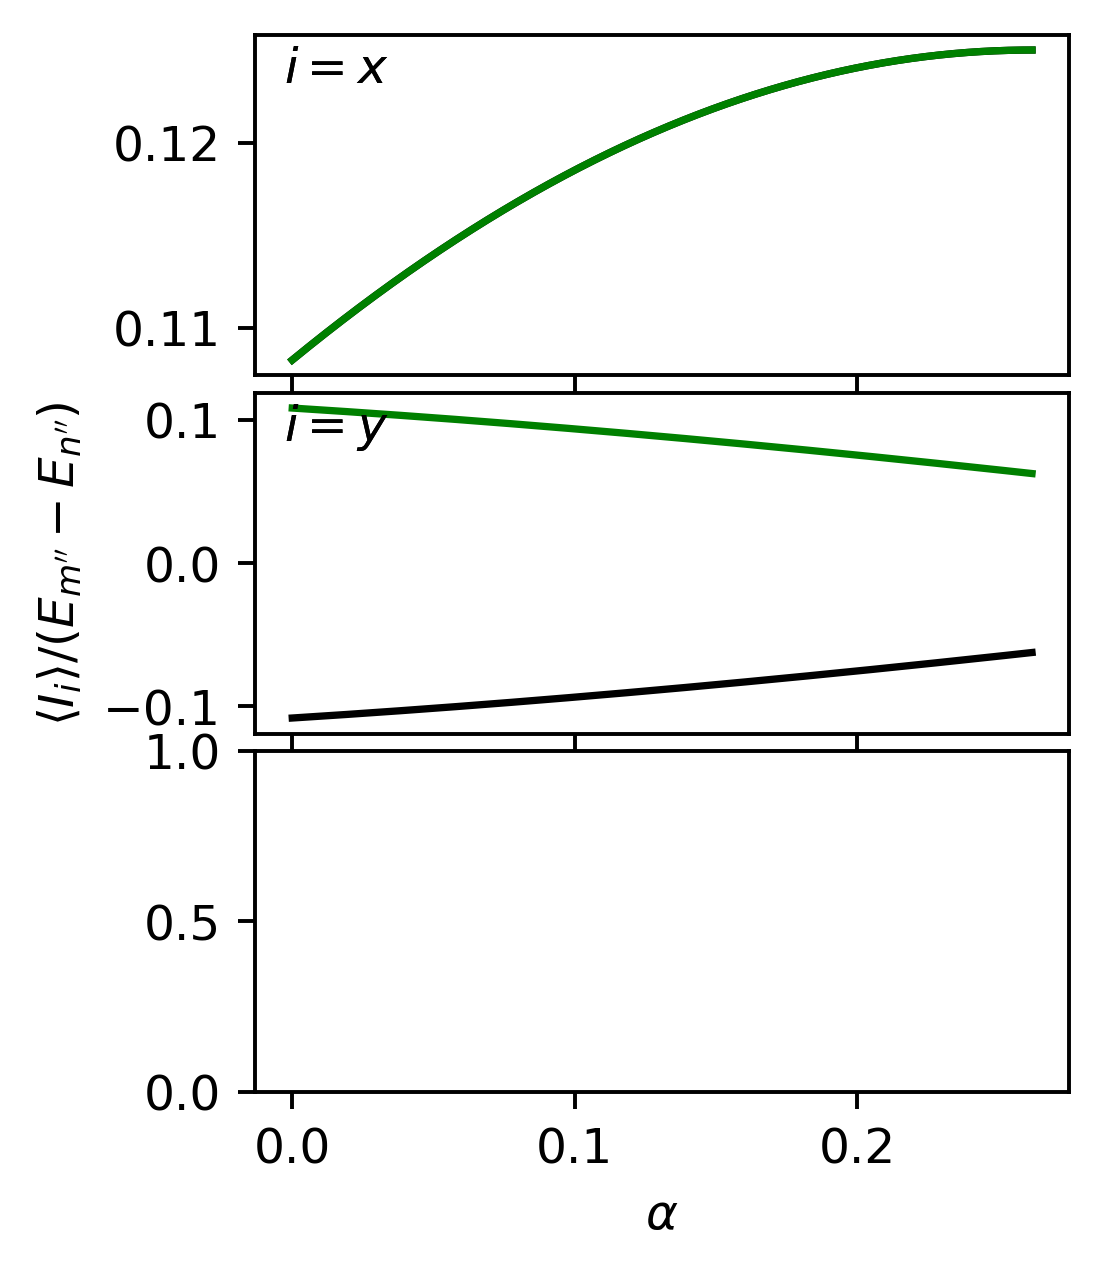

In [19]:
delta = np.linspace(0, np.pi/12, 5000)
xdata = {}
ydata = {}
cdata = {}
# xyz_data_labels = []
# fig, ax = plt.subplots(3,
#                        sharex=True,
#                        gridspec_kw = {'hspace': 0.05},
#                        figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
#                        dpi=450)
for i, d in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[d]
    xdata[d] = {}
    ydata[d] = {}
    cdata[d] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        wpq = sp.lambdify([sym.delta], sym.freq[d][tran])(delta)
        x = delta[wpq >= 0]
        y = wpq[wpq >= 0]
        y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
        _Iexp = Iexp[tran](delta, 0)
        if x.size != 0 and np.any(_Iexp != 0):
            c = _Iexp[wpq >= 0]
            if np.all(np.isclose(np.imag(c), np.zeros(x.size))):
                c = np.real(c)
            elif np.all(np.isclose(np.real(c), np.zeros(x.size))):
                c = np.imag(c)
            else:
                print('uh oh')
            xdata[d][tran] = x.copy()
            ydata[d][tran] = y.copy()
            cdata[d][tran] = (c/y).copy()
        #ax[i].plot(x, c, label=tran)

# mpl.style.use('default')
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/2, FIGSIZE[1]),
                       dpi=350)
cmin, cmax = 100, -100
for i, d in enumerate(cdata):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(cdata_list) != 0:
        _cmax, _cmin = find_max_min([(c) for c in cdata_list])
        if _cmax > cmax:
            cmax = _cmax
        if _cmin < cmin:
            cmin = _cmin
pcolors = ['k', 'g', 'r', 'c', 'm', 'y', 'b', 'tab:orange', 'tab:brown', 'tab:gray', 'r', 'g']
for i, d in enumerate(['x', 'y', 'z']):
    cdata_list = list(cdata[d].values())
    ydata_list = list(ydata[d].values())
    if len(ydata_list) != 0:
        ymax, ymin = find_max_min(ydata_list)
    for j, tran in enumerate(cdata[d]):
        x = xdata[d][tran]
        c = (cdata[d][tran])#/cmin
        ax[i].plot(x, c, color=pcolors[j])
        ax[i].text(0.1, 0.9,
                   r"$i = " + d + "$",
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
# D_label = sp.nsimplify(D, constants=[sp.pi])
# if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
# else:
#     ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[1].set_ylabel(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
ax[-1].set_xlabel(r'$\alpha$')
# #fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

In [ ]:
sym.E = [sym.eig[i][0] for i in range(4)]
sym.V = [None]*4
sym.V[0] = sym.eig[0][2][0]
sym.V[1] = sym.eig[1][2][0]*-sym.s/(sym.ap + sp.sqrt(sym.ap**2 + sym.s**2))
sym.V[2] = sym.eig[2][2][0]*-sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
sym.V[3] = sym.eig[3][2][0]*sym.s/(-sym.am + sp.sqrt(sym.am**2 + sym.s**2))*sym.s/(sym.am + sp.sqrt(sym.am**2 + sym.s**2))
_E, _V = ([None]*len(sym.V) for i in range(2))
sym.subs = {sym.ap: sym.alpha + sp.cos(sym.D), sym.am: sym.alpha - sp.cos(sym.D), sym.s: sp.sin(sym.D)}
for i in range(4):
    sym.E[i] = sym.E[i]
    sym.V[i] = sp.simplify(sym.V[i])#.subs(sym.subs).subs(sym.D, 0)
    display(sym.E[i], sym.V[i])
sym.E[2] = -sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.E[3] = sym.am*sp.sqrt(1 + (sym.s/sym.am)**2) - sp.Rational(1, 2)
sym.V[2] = sp.Matrix([0, 1, 0, -sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2))])
sym.V[3] = sp.Matrix([0, sym.s/(sym.am + sym.am*sp.sqrt(1 + (sym.s/sym.am)**2)), 0, 1])

In [ ]:
for i in range(4):
    display(sym.E[i], sym.V[i])#.subs(sym.subs))#.subs(sym.D, 0))

In [ ]:
mpl.style.use('seaborn')
mpl.style.use('seaborn-bright')
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6/2/2#/10#np.sin(0)
num_subs = {sym.alpha: alpha, sym.D: D}
fig, ax = plt.subplots(2,
                       sharex=True,
                       dpi=400,
                       gridspec_kw={'hspace':0.01},
                       figsize=(FIGSIZE[0]/1.6, FIGSIZE[1]))
sym.EV = {}
sym.EV_norm = {}
for i in range(4):
    for j, e in enumerate(sym.V[i]):
        if e == 1:
            label = str(sp.nsimplify(np.arange(I, -I - 1, -1)[j]))
            sym.EV[label] = (sym.E[i], sym.V[i])
    E, V = sym.EV[label]
    norm = 1/sp.sqrt(V.dot(V))
    V_norm = sp.trigsimp(norm*V)
    sym.EV_norm[label] = (E, V_norm)
    y = sp.lambdify([sym.alpha, sym.D], E.subs(sym.subs))(alpha, D)
    y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
    ax[0].plot(alpha, y, label=f"{label}''")
sym.f = {}
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange', 'midnightblue', 'lawngreen', 'teal', 'thistle']
color_i = 0
for p in sym.EV:
    for q in sym.EV:
        Ep = sym.EV[p][0]
        Eq = sym.EV[q][0]
        f = Eq - Ep
        y = sp.lambdify([sym.alpha, sym.D], f.subs(sym.subs))(alpha, D)
        if type(y) == int and y == 0:
            pass
        else:
            x = alpha[y >= 0]
            y = y[y >= 0]
            if y.size > 0:
                sym.f[(p, q)] = f
                y[:-1][np.abs(np.diff(y)) > 0.1] = np.nan
                ax[1].plot(x, y, label=f"{p}'' --> {q}''", c=colors[color_i])
                color_i += 1
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.p >= 100 or D_label.q >= 100:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
ax[1].set_ylabel(r"$E_{m''} - E_{n''}$")
ax[0].set_ylabel(r"$E_{m''}$")
ax[0].legend()
ax[1].legend(loc=(1, 0.1))
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'energy_trans.jpg'), bbox_inches='tight')

In [ ]:
# sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
# sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
# sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
# sym.Iexp = {}
# sym.Iexp['x'] = {}
# sym.Iexp['y'] = {}
# sym.Iexp['z'] = {}
# V10 = sp.Matrix([1, 0])
# V01 = sp.Matrix([0, 1])
# c = [None]*3
# c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
# c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
# c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
# beta = {}
# beta['x'] = sp.Matrix(np.zeros((4, 4)))
# beta['y'] = sp.Matrix(np.zeros((4, 4)))
# beta['z'] = sp.Matrix(np.zeros((4, 4)))
# for xyz in ['x', 'y', 'z']:
#     for i, p in enumerate(sym.V_mbasis):
#         for j, q in enumerate(sym.V_mbasis):
#             Ep, Eq = sym.EV[p][0], sym.EV[q][0]
#             (Vp, normp), (Vq, normq) = sym.V_mbasis[p], sym.V_mbasis[q]
#             wpq = Eq - Ep
#             norm = sp.simplify(normp*normq)
#             beta[xyz][i, j] = 4*Vp.dot(sym.I[xyz]*Vq)
# for i, p in enumerate(sym.V_mbasis):
#     for j, q in enumerate(sym.V_mbasis):
#         compi, compj = 0, 0
#         for m, xyz in enumerate(['x', 'y', 'z']):
#             betam = beta[xyz][i, j]
#             compi += c[m]*sp.re(betam)
#             compj += c[m]*sp.im(betam)
#         norm = sp.sqrt(compi**2 + compj**2)
#         if norm != 0:
#             nhat = sp.Matrix([compi, compj, 0])/norm
#             mid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
#             factor = sp.simplify((V01.T*mid*V10)[0])
#             display(factor)
#             _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
#             Iexp = _Iexp# + sp.conjugate(_Iexp)
#             sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# Warning: this cell takes about 1-2 minutes to run
sym.sigma1, sym.sigma2, sym.sigma3, sym.t = sp.symbols('sigma_1 sigma_2 sigma_3 t')
sym.sigma = sp.Matrix([sym.sigma1, sym.sigma2, sym.sigma3])
sigma_subs = {sym.sigma1: msigma(1), sym.sigma2: msigma(2), sym.sigma3: msigma(3)}
sym.Iexp = {}
sym.Iexp['x'] = {}
sym.Iexp['y'] = {}
sym.Iexp['z'] = {}
V10 = sp.Matrix([1, 0])
V01 = sp.Matrix([0, 1])
c = [None]*3
c[0] = sp.Matrix([1, 0, 0]).dot([1, 0, 0])
c[1] = sp.Matrix([1, 0, 0]).dot([0, 1, 0])
c[2] = sp.Matrix([1, 0, 0]).dot([0, 0, 1])
for xyz in ['x', 'y', 'z']:
    for p in sym.EV:
        for q in sym.EV:
            Ep, Eq = sym.EV[p][0], sym.EV[q][0]
            Vp, Vq = sym.EV[p][1], sym.EV[q][1]
            wpq = Eq - Ep
            beta = Vp.dot(sym.I[xyz]*Vq)
            compi, compj = 0, 0
            for m, xyz2 in enumerate(['x', 'y', 'z']):
                betam = Vp.dot(sym.I[xyz2]*Vq)
                compi += c[m]*sp.re(betam)
                compj += c[m]*sp.im(betam)
            nhat = (sp.Matrix([compi, compj, 0])/sp.sqrt(compi**2 + compj**2))
            Vmid = (nhat.cross(sym.sigma)[2]).subs(sigma_subs)
            _Iexp = wpq*((V01.T*Vmid).dot(V10))*beta/(2*(2*I + 1))*sp.exp(sp.I*wpq*sym.t)
            Iexp = _Iexp# + sp.conjugate(_Iexp)
            sym.Iexp[xyz][(p, q)] = sp.lambdify([sym.alpha, sym.D, sym.t], Iexp.subs(sym.subs).subs(sym.delta, sym.D/2))

In [ ]:
# # Run above cell before running this one if it has been a while...
# mpl.style.use('seaborn')
# alpha = np.linspace(0, 1.5, 5000)[1:]
# D = np.pi/24#/10#np.sin(0)
# fig, ax = [None]*3, [None]*3
# fig[0], ax[0] = plt.subplots(1, dpi=150)
# fig[1], ax[1] = plt.subplots(1, dpi=150)
# fig[2], ax[2] = plt.subplots(1, dpi=150)
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange']
# color_i = 0
# for i, xyz in enumerate(['x', 'y', 'z']):
#     Iexp = sym.Iexp[xyz]
#     for j, tran in enumerate(Iexp):
#         p, q = tran
#         y = Iexp[tran](alpha, D)# + np.conjugate(Iexp[tran](alpha, D))
#         #print(y, type(y))
#         cond = type(y) == int and y == 0\
#                or type(y) == float\
#                or type(y) == np.float64 or np.all(np.isclose(y, np.zeros(alpha.size)))
#         if cond:
#             pass
#         else:
#             y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
#             ax[i].plot(alpha, np.real(y), label=f"{p}'' --> {q}''", color=colors[color_i])
#             color_i += 1
#     ax[i].set_ylabel(r'$\langle I_' + xyz + r'\rangle$ $(\hbar/kT)$')
#     ax[i].legend()
#     ax[i].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(sp.nsimplify(D, constants=[sp.pi]), fold_short_frac=True)}$');

In [ ]:
alpha = np.linspace(0, 1.5, 5000)
D = np.arccos(0.9917172851021455)#np.pi/6
xdata = {}
ydata = {}
cdata = {}
xyz_data_labels = []
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    xdata[xyz] = {}
    ydata[xyz] = {}
    cdata[xyz] = {}
    for j, t in enumerate(Iexp):
        p, q = t
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        f = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))
        y = f(alpha, D)
        c = Iexp[t](alpha, D, 0)
        if not np.all(np.isclose(np.imag(c), np.zeros(alpha.size))):
            pass#c = np.imag(c)
        else:
            c = np.real(c)
        cond = type(y) == int and y == 0\
               or type(c) == int and c == 0\
               or type(c) == float\
               or np.all(np.isclose(c, np.zeros(alpha.size)))
        if cond:
            pass
        else:
            x = alpha[y >= 0]
            c = c[y >= 0]
            y = y[y >= 0]
            if y.size == 0:
                pass
            else:
                y[:-1][np.abs(np.diff(y)) > 0.01] = np.nan
                xdata[xyz][t] = x
                ydata[xyz][t] = y
                cdata[xyz][t] = c
    if list(cdata[xyz].values()) != []:
        xyz_data_labels.append(xyz)

mpl.style.use('default')
fig, ax = plt.subplots(len(xyz_data_labels),
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=450)
cmin, cmax = 100, 0
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        _cmax, _cmin = find_max_min([np.abs(c) for c in cdata_list])
        if _cmax > cmax:
            cmax = _cmax
        if _cmin < cmin:
            cmin = _cmin
for i, xyz in enumerate(xyz_data_labels):
    cdata_list = list(cdata[xyz].values())
    ydata_list = list(ydata[xyz].values())
    if len(cdata_list) > 0:
        ymax, ymin = find_max_min(ydata_list)
        norm = plt.Normalize(cmin, cmax)
        for j, t in enumerate(cdata[xyz]):
            x = xdata[xyz][t]
            y = ydata[xyz][t]
            c = np.abs(cdata[xyz][t])/cmax/y
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = mpl.collections.LineCollection(segments, cmap='hot', norm=norm)
            lc.set_array(c)
            lc.set_linewidth(2)
            line = ax[i].add_collection(lc)
        ax[i].set_xlim(alpha.min(), alpha.max())
        ax[i].set_ylim(ymin, ymax)
        ax[i].set_ylabel(r"$ E_{m''} - E_{n''}$")
        ax[i].set_facecolor("black")
        ax[i].text(0.1, 0.9,
                   r"$i = " + xyz + "$",
                   color='w',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax[i].transAxes)
D_label = sp.nsimplify(D, constants=[sp.pi])
if D_label.is_rational and (D_label.p >= 100 or D_label.q >= 100):
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {np.round(D, 3)}$')
else:
    ax[-1].set_xlabel(r'$\alpha$ with ' + fr'$D = {sp.latex(D_label, fold_short_frac=True)}$');
cbar = fig.colorbar(line, ax=ax[0:], location='right')#, shrink=0.6)
cbar.set_label(r"$\langle I_i \rangle/(E_{m''} - E_{n''})$")
#fig.savefig(op.join(ROOT, 'reports', 'nuclear_hamiltonian', 'magmom.jpg'), bbox_inches='tight')

In [ ]:
alpha = 100
D = 0.01
fig, ax = plt.subplots(3,
                       sharex=True,
                       gridspec_kw = {'hspace': 0.05},
                       figsize=(FIGSIZE[0]/1.5, FIGSIZE[1]),
                       dpi=200)
data = {}
for i, xyz in enumerate(['x', 'y', 'z']):
    Iexp = sym.Iexp[xyz]
    data[xyz] = {}
    for j, tran in enumerate(Iexp):
        p, q = tran
        Ep, Eq = sym.EV[p][0], sym.EV[q][0]
        w = sp.lambdify([sym.alpha, sym.D], (Eq - Ep).subs(sym.subs))(alpha, D)
        cond1 = w != 0 and w > 0
        if cond1:
            t = np.linspace(0, 2*np.pi)/w
            y = Iexp[tran](alpha, D, t)
            cond2 = (type(y) == float and np.isnan(y)) or (type(y) == int)
            if cond2:
                pass
            else:
                data[xyz][tran] = (y, w, t)
                #p = ax[i].plot(t*wpq, np.real(y))
                #ax[i].plot(t*wpq, np.imag(y), '.', c=p[-1].get_color())
for i, tran in enumerate(data['x']):
    Ix, wx, tx = data['x'][tran]
    Iy, wy, ty = data['y'][tran]
    Itot = Ix*np.cos(wx*tx) + Iy*np.sin(wy*ty)
    px = ax[0].plot(tx*wx, np.real(Ix))
    py = ax[1].plot(ty*wy, np.real(Iy))
    ptot = ax[2].plot(tx*wx, np.real(Itot))
    ax[0].plot(tx*wx, np.imag(Ix), '-.', c=px[-1].get_color())        
    ax[1].plot(ty*wy, np.imag(Iy), '-.', c=py[-1].get_color())
    ax[2].plot(tx*wx, np.imag(Itot), '-.', c=ptot[-1].get_color())
    
ax[-1].set_xlabel(r'$ \omega t $')
ax[0].set_ylabel(r'$ I_x $')
ax[1].set_ylabel(r'$ I_y $')

# Parameters

In [ ]:
sym.w1, sym.w2, sym.wi = sp.symbols('omega_1 omega_2 omega_i', real=True, positive=True)
sym.x, sym.y, sym.p1, sym.p2, sym.r, sym.wt = sp.symbols(r'x y p_1 p_2 r \tilde{w}_2', real=True)
sym.p1, sym.p2, sym.p3, sym.p4, sym.p5, sym.p6 = sp.symbols('p_1 p_2 p_3 p_4 p_5 p_6', real=True)
f1 =  sym.p1 + sym.p2*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p3*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
f2 =  sym.p4 + sym.p5*sp.sqrt(sym.ap**2 + sym.s**2) + sym.p6*sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
subs = {sym.am*sp.sqrt(1 + sym.s**2/sym.am**2): sym.x, sp.sqrt(sym.ap**2 + sym.s**2): sym.y}
exp1 = f1/f2 - sym.w1/sym.w2
exp2 = sym.wi*f2 - sym.w2
sol = sp.nonlinsolve([exp1.subs(subs), exp2.subs(subs)], [sym.x, sym.y])
xy_sol = list(sol)[0]
display(exp1, exp2, xy_sol)

In [ ]:
sym.c1, sym.c2 = sp.symbols('c_1 c_2', real=True)
x, y = xy_sol
exp1 = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2) + sym.c1
exp2 = sp.sqrt(sym.ap**2 + sym.s**2) - sym.c2
as_sol = sp.solve([exp1, exp2], [sym.ap, sym.am])
display(exp1, exp2, as_sol[0], as_sol[1])

In [ ]:
J = sp.symbols('J', real=True)
subs = {sym.s: sp.sin(sym.D)}
exp1 = ((sym.alpha + sp.cos(sym.D))**2 - as_sol[1][0]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
exp2 = ((sym.alpha - sp.cos(sym.D))**2 - as_sol[1][1]**2).subs(subs).expand().trigsimp().subs(sp.cos(sym.D), J)
#sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, sp.cos(sym.D)]).simplify()
sol = sp.nonlinsolve([exp1, exp2], [sym.alpha, J]).simplify()
display(exp1, exp2, sol)

In [ ]:
def get_c(w1, w2, wi, _p1, _p2):
    p1, p2, p3 = tuple(_p1)
    p4, p5, p6 = tuple(_p2)
    
    den = wi*(p2*p6 - p3*p5)
    c1_num = w1*p5 - w2*p2 + wi*(p2*p4 - p1*p5)
    c2_num = w1*p6 - w2*p3 + wi*(p3*p4 - p1*p6)

    if den == 0:
        return np.inf, np.inf
    else:
        return c1_num/den, c2_num/den

v = [None]*3
v[0] = sym.s
v[1] = sp.sqrt(sym.ap**2 + sym.s**2)
v[2] = sym.am*sp.sqrt(1 + sym.s**2/sym.am**2)
w1 = 11.7*mega
w2 = w1 + 8.8*mega
wi = 1.6*7.292*mega
for t1 in sym.f:
    for t2 in sym.f:
        f1 = sym.f[t1]
        f2 = sym.f[t2]
        p1, p2 = (np.zeros(3) for i in range(2))
        for i in range(3):
            n = 1
            if i == 0:
                n = 0
            p1[i], p2[i] = (f1.as_expr().coeff(v[i], n), f2.as_expr().coeff(v[i], n))
        c1, c2 = get_c(w1, w2, wi, p1, p2)
        if not np.all([np.isfinite(val) for val in [c1, c2]]):
            continue
        if c1**2 + c2**2 - 2 < 0:
            continue
        factor = np.sqrt(2*(c1**2 + c2**2 - 2))
        alpha = factor/2 
        cosD = (c1**2 - c2**2)/2/factor
        if cosD > 1 or -cosD > 1:
            continue
        cosD = np.abs(cosD)
        D = np.arccos(cosD)
        subs = {sym.alpha: alpha, sym.D: D}
        f1_val = np.float(f1.subs(sym.subs).subs(subs).evalf())
        f2_val = np.float(f2.subs(sym.subs).subs(subs).evalf())
        Iexp_t1 = np.real(sym.Iexp['y'][t1](alpha, D))
        Iexp_t2 = np.real(sym.Iexp['y'][t2](alpha, D))
        if not np.isclose([f1_val/f2_val], [w1/w2]) or np.any(np.isnan([Iexp_t1, Iexp_t2])):
            continue
        if D > np.pi/6:
            continue
        print('trans: ', t1, t2)
        print("params: ", alpha, cosD)
        print("freqs: ", f1_val, f2_val)
        print("checks: ", wi*f1_val, w1, f1_val/f2_val, w1/w2, wi*f2_val, w2)
        print('-'*80)

In [ ]:
from scipy.constants import h, hbar, e
I = 3/2
gamma = 7.315021*mega
Bi = 1.60
Q = nmr.get_Q('As', 75).n
wi = gamma*Bi
cosD = 0.9917172851021455
alpha = 0.3822292454941639
delta = np.arccos(cosD)/2
rho = 1/(1 - 2*np.sin(delta)**2)
wQ = alpha*wi/rho
Vzz = wQ*(4*I*(2*I - 1)*h)/(3*e*Q)
eta = np.sqrt((rho**2 - 1)*3)
Bi, gamma, wi, Q, wQ, Vzz, eta